# Zonal Statistics - continuous values

In [2]:
import glob, os
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterstats
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

print('All libraries successfully imported!')
print(f'Rasterstats : {rasterstats.__version__}')

All libraries successfully imported!
Rasterstats : 0.14.0


## Set parameters

Choose statistics :
- min
- max
- mean

In [3]:
index_name = 'NDVI'

stat_name = 'mean'

nodata_val = -10000

### Date
The date must be in each image filename. `begin_date` is the first position of the date

E.g. : "SITE_3_**2**0181108_NDVI.tif" --> **begin_date = 8**

In [4]:
format     = '%Y%m%d' # format : YYYYMMDD
begin_date = 8

## Set directory

In [5]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'


# Rasters files directory
raster_file_list = sorted(glob.glob(f'{work_path}{index_name}/*{index_name}.tif'))

print('Raster files timeseries :')
for raster_file in raster_file_list:
    print(raster_file)

# Vector file
vector_file  = f'{work_path}IN_SITU/NAMUR_2020_IN_SITU_ROI.shp'

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'
zonal_stat_csv  = f'{zonal_stat_path}zonal_stat_cont_{index_name}.csv'
zonal_stat_shp  = f'{zonal_stat_path}zonal_stat_cont_{index_name}.shp'

Path(zonal_stat_path).mkdir(parents=True, exist_ok=True)

Raster files timeseries :
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200116T105309_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200212T104049_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200316T104709_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200417T104021_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200520T105031_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200621T103629_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200719T105031_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200813T104629_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20200914T104031_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20201019T103959_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_20201118T104329_NDVI.tif
/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/NDVI/T31UFS_202

## Check if raster and vector are projected to the same CRS

In [6]:
gdf = gpd.read_file(vector_file)
src = rasterio.open(raster_file_list[6], "r")

crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

CRS are the same : EPSG:32631 = EPSG:32631


**Check if raster and vector file are intersecting**

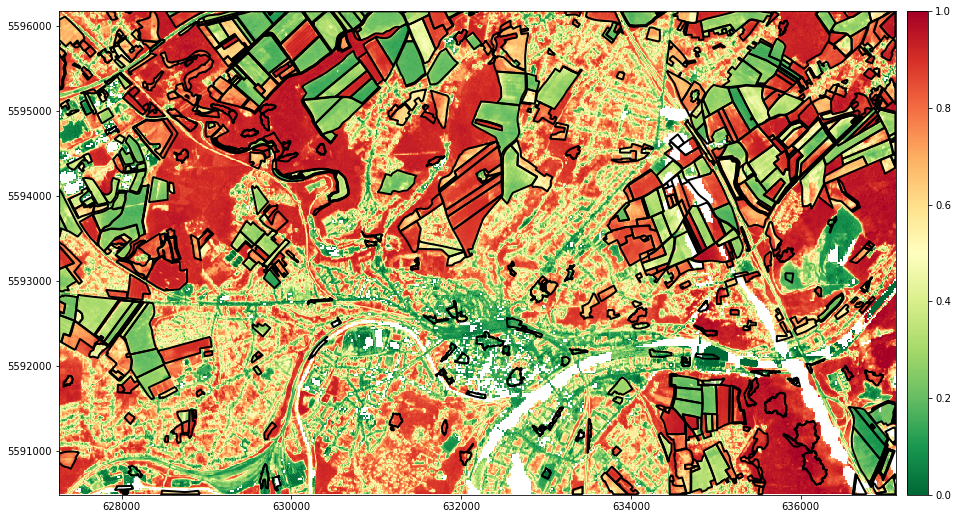

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

# Plot vector
gdf.plot(facecolor='none', edgecolor='black', linewidth = 2, ax=ax)

# Plot image
color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

im_rio = rasterio.plot.show(src, cmap=reversed_color_map, vmin=0, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)


plt.box(False)

## Get date of each image

In [8]:
dict_list = []

for im in raster_file_list:
            
        date_str = os.path.basename(im)[begin_date-1:begin_date-1+8]

        date_im = datetime.datetime.strptime(date_str, format).date()

        dict_list.append({'date': date_im,
                            'im_path': im})

im_date_path_df = pd.DataFrame.from_dict(dict_list).sort_values('date')

display(im_date_path_df)

,date,im_path
0,2020-01-16,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
1,2020-02-12,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
2,2020-03-16,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
3,2020-04-17,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
4,2020-05-20,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
5,2020-06-21,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
6,2020-07-19,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
7,2020-08-13,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
8,2020-09-14,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...
9,2020-10-19,/export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/...


## Compute zonal statistics

In [30]:
df_list = []

for i, row in im_date_path_df.iterrows():
    im       = row['im_path']
    date_str = row['date']

    print(date_str)

    df = pd.DataFrame(zonal_stats(gdf,
                                  im,
                                  stats=stat_name,
                                  nodata=nodata_val))
    
    df = df.rename(columns={stat_name: date_str})
    df_list.append(df)

dfs = pd.concat(df_list, axis=1).round(4)

display(dfs)

2020-01-16
2020-02-12
2020-03-16
2020-04-17
2020-05-20
2020-06-21
2020-07-19
2020-08-13
2020-09-14
2020-10-19
2020-11-18
2020-12-18


,2020-01-16,2020-02-12,2020-03-16,2020-04-17,2020-05-20,2020-06-21,2020-07-19,2020-08-13,2020-09-14,2020-10-19,2020-11-18,2020-12-18
0,0.7395,0.1272,0.8413,0.8236,0.6891,0.7709,0.7815,0.4859,0.5481,0.6841,0.7976,0.7610
1,0.7475,NaN,0.7638,0.8128,0.7638,0.5150,0.7029,0.3949,0.6004,0.6972,0.7914,0.7185
2,0.7392,NaN,0.7566,0.5829,0.5943,0.7457,0.7798,0.5395,0.4648,0.5568,0.6331,0.6759
3,0.6598,0.6801,0.6979,0.8038,0.8918,0.7204,0.6554,0.6826,0.7663,0.8264,0.6573,0.6309
4,0.7268,NaN,0.7962,0.8004,0.5363,0.7735,0.8932,0.6061,0.5772,0.5625,0.8323,0.8127
...,...,...,...,...,...,...,...,...,...,...,...,...
728,NaN,0.3371,0.5573,0.6364,0.9057,0.6302,0.9453,0.8781,0.8661,0.8224,0.6595,0.5909
729,0.5909,0.1317,0.4802,0.6402,0.7913,0.5485,0.8005,0.7715,0.8120,0.7472,0.6570,0.5920
730,0.6248,0.2534,0.5915,NaN,0.8734,0.9049,0.9240,0.8966,0.8531,0.8123,0.6661,0.6007
731,0.2090,0.1992,0.1808,0.1673,0.1392,0.1767,0.1832,0.2076,0.1431,0.2825,0.2529,0.2505


## Plot timeseries

In [31]:
df = dfs

display(df)

df['parcel_id'] = df.index

df = df.set_index('parcel_id')

df = df.transpose()

df['date'] = df.index

df = df.melt(id_vars=['date'], var_name='parcel_id')

df = df.merge(gdf, left_on='parcel_id', right_on='id')

df = df[['date','parcel_id','value','sub_nb','sub','class_nb','class']]

display(df)


,2020-01-16,2020-02-12,2020-03-16,2020-04-17,2020-05-20,2020-06-21,2020-07-19,2020-08-13,2020-09-14,2020-10-19,2020-11-18,2020-12-18
0,0.7395,0.1272,0.8413,0.8236,0.6891,0.7709,0.7815,0.4859,0.5481,0.6841,0.7976,0.7610
1,0.7475,NaN,0.7638,0.8128,0.7638,0.5150,0.7029,0.3949,0.6004,0.6972,0.7914,0.7185
2,0.7392,NaN,0.7566,0.5829,0.5943,0.7457,0.7798,0.5395,0.4648,0.5568,0.6331,0.6759
3,0.6598,0.6801,0.6979,0.8038,0.8918,0.7204,0.6554,0.6826,0.7663,0.8264,0.6573,0.6309
4,0.7268,NaN,0.7962,0.8004,0.5363,0.7735,0.8932,0.6061,0.5772,0.5625,0.8323,0.8127


,date,parcel_id,value,sub_nb,sub,class_nb,class
0,2020-01-16,0,0.7395,3199,Grassland and meadows,319,Grassland and meadows
1,2020-02-12,0,0.1272,3199,Grassland and meadows,319,Grassland and meadows
2,2020-03-16,0,0.8413,3199,Grassland and meadows,319,Grassland and meadows
3,2020-04-17,0,0.8236,3199,Grassland and meadows,319,Grassland and meadows
4,2020-05-20,0,0.6891,3199,Grassland and meadows,319,Grassland and meadows
...,...,...,...,...,...,...,...
8791,2020-08-13,732,0.1960,7211,Bare soils,721,Bare soils
8792,2020-09-14,732,0.1671,7211,Bare soils,721,Bare soils
8793,2020-10-19,732,0.2447,7211,Bare soils,721,Bare soils
8794,2020-11-18,732,0.2429,7211,Bare soils,721,Bare soils


In [32]:
fig = px.line(df,
              x='date',
              y='value',
              color='class_nb',
              line_group='parcel_id',
              hover_data=['sub_nb','sub'],
              title= 'title')

fig.show()

## Write output to shapefile

In [91]:
gdf_with_zonal_stat = pd.concat([gdf, dfs], axis=1, join="inner")

gdf_with_zonal_stat.columns = gdf_with_zonal_stat.columns.astype(str)

gdf_with_zonal_stat.to_file(zonal_stat_shp)

print(f'SHP file was created : {zonal_stat_shp}')

SHP file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cont_NDVI.shp


## Write output to CSV

In [92]:
gdf_with_zonal_stat = pd.concat([gdf, dfs], axis=1, join="inner")

gdf_with_zonal_stat = gdf_with_zonal_stat.drop(columns='geometry')

gdf_with_zonal_stat.to_csv(zonal_stat_csv)

print(f'CSV file was created : {zonal_stat_csv}')

CSV file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cont_NDVI.csv
